# Celestial mechanics with the `celmech` code

**Sam Hadden** (CITA)

Collaborators: **Dan Tamayo** (Princeton), **David Hernandez** (CfA)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy import init_printing
init_printing()

# What is `celmech`?

- Code for celestial mechanics calculations
    - Calculate disturbing function expansion
    - Construct, manipulate, and integrate Hamiltonian equations of motion
    - Much more...
- Developed mainly in `python`
- Designed to work with the [`rebound`](https://github.com/hannorein/rebound) N-body code (Rein & Liu 2012)
- Symbolic mathematics with [`sympy`](https://www.sympy.org/en/index.html) (Meurer et. al. 2017)

# Where is `celmech`?

- PyPI: ``pip install celmech``
- GitHub reposity at [github.com/shadden/celmech](https://github.com/shadden/celmech) 
    - Includes lots of Jupyter notebook examples
- Documentation at [celmech.readthedocs.io](https://celmech.readthedocs.io)
- This notebook is available on [GitHub](https://github.com/shadden/CelmechTutorial_SaoPauloState_Aug2022)!

# Basic principles
 - $N$-body codes like `rebound` integrate equations of motion directly:
    $$
    \dot{\mathbf{r}}_i = \frac{1}{m_i}\mathbf{p_i}\\
    \dot{\mathbf{p}}_i = -\sum_{i\ne j}Gm_im_j\frac{(\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3}
    $$


# Basic principles
- `celmech` works with approximate equations of motion.
    - Derived from disturbing function expansion of Hamiltonian in powers of $e$ and $s = \sin(I/2)$:
 $$
 \begin{multline}
 -\frac{Gm_im_j}{|\mathbf{r}_i - \mathbf{r}_j |} +\mathrm{indirect~terms^*}
 =\\ 
 -\frac{Gm_im_j}{a_j}
      \sum_{\bf k}     
     \sum_{\nu_1,\nu_2,\nu_3,\nu_4=0}^\infty                       
     \tilde{C}_{\bf k}^{{\nu}}(\alpha)
     s_i^{|k_5|+2\nu_1}
     s_j^{|k_6|+2\nu_2}
     e_i^{|k_3|+2\nu_3}
     e_i^{|k_4|+2\nu_4}
     \\
     \times \cos(k_1\lambda_j+k_2\lambda_i+k_3\varpi_i+k_4\varpi_j+k_5\Omega_i+k_6\Omega_j)
 \end{multline}
$$


- Equations formulated in canonical "action-angle" variables
- Allows theoretical insights and potentially faster integration

'*': coodinate-system dependent

# An example
A system of two Earth-mass planets near a 3:2 mean motion resonance

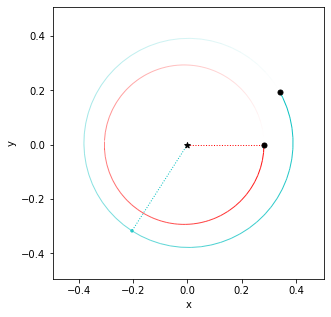

In [2]:
import rebound
rebound_sim = rebound.Simulation()
rebound_sim.add(m=1)
rebound_sim.add(m=3e-6,P = 1, e = 0.04)
rebound_sim.add(m=3e-6,P = 3 / 2, e = 0.02,l=0.5,pomega = np.pi+1)
rebound.OrbitPlot(rebound_sim,color=True,periastron=True);

In [3]:
#make an extra copy of our simulation for higher-order model later
sim2=rebound_sim.copy()

# Initializing a ``celmech`` model 
- Create `Poincare` and `PoincareHamiltonian` instances
- Initialize directly from a ``rebound`` simulation

In [4]:
from celmech import Poincare, PoincareHamiltonian
poincare_particles = Poincare.from_Simulation(rebound_sim)
Hp = PoincareHamiltonian(poincare_particles)

# The ``Poincare`` class 
- Represents system in terms of canonical variable pairs:
 $$\begin{align}
 \Lambda_i&= \mu_i\sqrt{GM_ia_i} ~;~ \lambda_i \\
 (\eta_i,\kappa_i)&\approx \sqrt{\Lambda_i}e_i \times(-\sin\varpi_i,\cos\varpi_i)\\
  (\rho_i,\sigma_i)&\approx \sqrt{\Lambda_i}\sin(I_i/2) \times(-\sin\Omega_i,\cos\Omega_i)\\
 \end{align}$$

In [5]:
type(poincare_particles)

celmech.poincare.Poincare

In [6]:
qp_pairs = poincare_particles.qp_pairs
qp_pairs

[(λ₁, Λ₁), (η₁, κ₁), (ρ₁, σ₁), (λ₂, Λ₂), (η₂, κ₂), (ρ₂, σ₂)]

# The ``Poincare`` class 
- Stores numerical values of canonical variables

In [7]:
Lambda1 = qp_pairs[0][1]
Lambda1, poincare_particles.qp[Lambda1]

(Λ₁, 1.625772780575234e-06)

- Also provides orbital mass, orbital elements, etc.

In [8]:
G = poincare_particles.G
particle = poincare_particles.particles[1]
particle.mu * np.sqrt(G * particle.M * particle.a)

1.625772780575234e-06

# The ``PoincareHamiltonian`` class 
- Represents a planetary system's Hamiltonian


In [9]:
type(Hp)

celmech.poincare.PoincareHamiltonian

- The ``H`` attribute stores the symbolic Hamiltonian
    - Keplerian terms upon intialization 

In [10]:
Hp.H

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

 - Or, in orbital elements: 
 $$
 -\frac{Gm_*m_1}{2a_1}-\frac{Gm_*m_2}{2a_2}
 $$

# The ``PoincareHamiltonian`` class 
- Stores numerical values of symbolic parameters as well

In [11]:
Hp.N_H

  1.34999595001215e-17   1.34999595001215e-17
- ──────────────────── - ────────────────────
            2                      2         
          Λ₂                     Λ₁          

# Building a Hamiltonian
- Users build up a Hamiltonian by selecting and adding disturbing function terms
- ``PoincareHamiltonian`` includes an extensive interface for specifying and adding terms
- We'll add terms for the 3:2 MMR

In [12]:
Hp.add_MMR_terms(p=3,q=1,max_order=1,indexIn=1,indexOut=2)

- The symbolic Hamiltonian is updated with the newly-added terms

In [13]:
Hp.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                            
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2}
                                                               ⎜   _______________       _______________ ⎟                            
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠                            
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ─────────────────────────
                                                  a_{2,0}                                                                             
                                                                                                                                      

                                    ⎛η₂⋅sin(2⋅λ₁ - 3⋅λ

# Building a Hamiltonian
- Equivalent in terms of orbital elements:

In [14]:
Hp.df

<IPython.core.display.Math object>

# Integrating Hamilton's equations
 - Equations of motion automatically generated from the Hamiltonian
 - Integration and particle interface designed to mirror ``rebound``

In [15]:
rebound_particles = rebound_sim.particles
celmech_particles = Hp.particles

# times to save output
times = np.linspace(0,500 * rebound_particles[1].P,100)

# Arrays to store results
eIn_rebound,eIn_celmech = np.zeros((2,100))

# Main integration loop
for i,t in enumerate(times):
    rebound_sim.integrate(t)
    Hp.integrate(t)
    # save eccentricity of inner planet
    eIn_rebound[i] = rebound_particles[1].e
    eIn_celmech[i] = celmech_particles[1].e
    

# Comparing $N$-body and ``celmech``
- The simple ``celmech`` model shows fair agreement with direct $N$-body integration

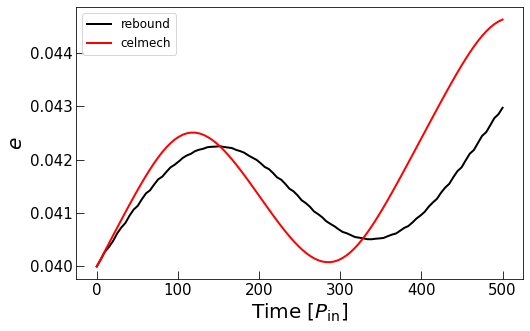

In [16]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax.plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$e$",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20);

# Making a more accurate ``celmech`` model
Now we'll include:
- Secular terms up to 2nd order in planets' eccentricities
- 3:2 resonant terms up to 3rd order in planets' eccentricities

In [17]:
pvars = Poincare.from_Simulation(sim2)
Hp = PoincareHamiltonian(pvars)

In [18]:
Hp.add_secular_terms(max_order=2,indexIn=1,indexOut=2,inclinations=False)
Hp.add_MMR_terms(p=3,q=1,max_order=3,indexIn=1,indexOut=2,inclinations=False)

# Terms included in the improved model
Many more disturbing function terms are now included:

- Secular terms:
$$
\tilde{C}_{(0,0,0,0,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_2^2
+\tilde{C}_{(0,0,0,0,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^2
+\tilde{C}_{(0,0,-1,1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2\cos(-\varpi_1+\varpi_2)
$$

# ...

- 6:4 terms:
$$
\tilde{C}_{(6,-4,0,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_2^2\cos(6\lambda_2-4\lambda_1-2\varpi_2)\\
+\tilde{C}_{(6,-4,-1,-1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2\cos(6\lambda_2-4\lambda_1-\varpi_1-\varpi_2)\\
+\tilde{C}_{(6,-4,-2,0,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2\cos(6\lambda_2-4\lambda_1-2\varpi_1)
$$

# ...
- 9:6 terms:
$$
\tilde{C}_{(9,-6,0,-3,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_2^3\cos(9\lambda_2-6\lambda_1-3\varpi_2)\\
+
\tilde{C}_{(9,-6,-1,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2^2\cos(9\lambda_2-6\lambda_1-\varpi_1-2\varpi_2)
\\
+
\tilde{C}_{(9,-6,-2,-1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2e_2\cos(9\lambda_2-6\lambda_1-2\varpi_1-\varpi_2)\\
+\tilde{C}_{(9,-6,-3,0,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^3\cos(9\lambda_2-6\lambda_1-3\varpi_1)
$$

# ...
- 3rd order 3:2 terms:
$$
\left(\tilde{C}_{(3,-2,0,-1,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_2^3 + 
\tilde{C}_{(3,-2,0,-1,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^2e_2\right)\cos(3\lambda_2-2\lambda_1-\varpi_2)\\
+\left(\tilde{C}_{(3,-2,-1,0,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_1e_2^2
+\tilde{C}_{(3,-2,-1,0,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^3\right)\cos(3\lambda_2-2\lambda_1-\varpi_1)\\
+
\tilde{C}_{(3,-2,1,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2^2\cos(3\lambda_2-2\lambda_1+\varpi_1-2\varpi_2)\\
+\tilde{C}_{(3,-2,-2,1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2e_2\cos(3\lambda_2-2\lambda_1-2\varpi_1+\varpi_2)
$$

These terms would be tedious to add by hand...

In [19]:
from celmech.lie_transformations import FirstOrderGeneratingFunction
chi = FirstOrderGeneratingFunction(pvars)
chi.add_zeroth_order_term(indexIn=1,indexOut=2)
chi.add_MMR_terms(2,1,indexIn=1,indexOut=2)
chi.add_MMR_terms(4,1,indexIn=1,indexOut=2)
chi.osculating_to_mean()

In [20]:
rebound_particles = sim2.particles
celmech_particles = Hp.particles
times = np.linspace(0,500 * rebound_particles[1].P,100)
eIn_rebound,eIn_celmech = np.zeros((2,100))
thetaIn_rebound,thetaIn_celmech = np.zeros((2,100))
energy = np.zeros(100)
for i,t in enumerate(times):
    sim2.integrate(t)
    Hp.integrate(t)
    energy[i] = Hp.calculate_energy()
    eIn_rebound[i] = rebound_particles[1].e
    eIn_celmech[i] = celmech_particles[1].e
    
    thetaIn_rebound[i] = -2*rebound_particles[1].l + 3*rebound_particles[2].l - rebound_particles[1].pomega
    thetaIn_celmech[i] = -2*celmech_particles[1].l + 3*celmech_particles[2].l - celmech_particles[1].pomega

# Improved agreement with higher order model
The higher-order model now shows excellent agreement with $N$-body

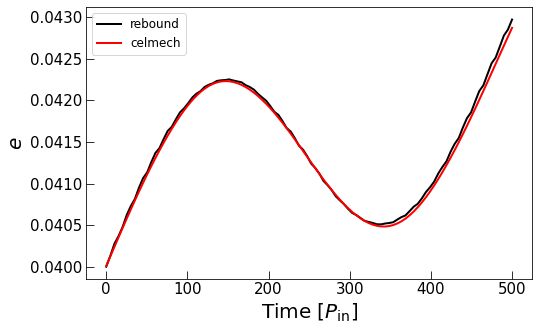

In [21]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax.plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$e$",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20);

# A simpler model via canonical transformations
- Present ``celmech`` equations involve 12 variables:

In [22]:
Hp.qp_vars

[λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂]

# A simpler model via canonical transformations
$$\newcommand{pd}[2]{\frac{\partial #1}{\partial #2}}$$
- Seek canonical transformation, 
     $$T : (q_i,p_i)\rightarrow (\phi_1,...,\phi_M,Q_1,Q_{N-M},I_1,...,I_M,P_1,...,P_{N-M})$$
   such that the new Hamiltonian, $H' = H \circ T^{-1}$ does not depend explicitly on the new coordinates, $\phi_i$.
- Hamilton's equations give $$\dot{I_i}=\pd{}{\phi_i}H'=0$$ so that the variables $I_i$ are conserved.
- Can consider equations with $N-M$ degrees of freedom: $$\begin{align}
\dot{Q_i} &= \pd{}{P_i}H'(Q,P;I)\\
\dot{P_i} &= -\pd{}{Q_i}H'(Q,P;I)\\
\end{align}$$ 

# A simpler model via canonical transformations
 - Present Hamiltonian depends on angle variables only via the combinations
 $$Q_i = 3\lambda_2 - 2\lambda_1 + \gamma_i$$
 - We'll use ``celmech`` to transform to new variables
 $$
 \begin{pmatrix}
 Q_1\\
 Q_2\\
 \phi_1\\
 \phi_2
 \end{pmatrix} = 
 \begin{pmatrix}
 -2 & 3 & 1 & 0 \\
 -2 & 3 & 0 & 1 \\
 -2 & 3 & 0 & 0 \\
 1 & -1 & 0 & 0
 \end{pmatrix}\cdot
  \begin{pmatrix}
 \lambda_1\\
 \lambda_2\\
 \gamma_1 \\
 \gamma_2
 \end{pmatrix}
 $$

# A simpler model via canonical transformations
 - Implement transformation with the `CanonicalTransformation` class

In [23]:
from celmech import CanonicalTransformation
from sympy import symbols
T = np.eye(Hp.N_dof,dtype=int)
T[0,:4] = [-2,3,1,0]
T[1,:4] = [-2,3,0,1]
T[2,:4] = [-2,3,0,0]
T[3,:4] = [1,-1,0,0]

# Symbols to use for new variables
new_qs = symbols("Q(1:3),phi(1:5)")
new_ps = symbols("P(1:3),I(1:5)")
new_qp_pairs = list(zip(new_qs,new_ps))

ct = CanonicalTransformation.from_poincare_angles_matrix(
    Hp.state,
    T,
    new_qp_pairs=new_qp_pairs
)
type(ct)

celmech.canonical_transformations.CanonicalTransformation

# A simpler model via canonical transformations
 - `new_to_old` transforms expressions in terms of new variables to expressions in terms of old variables

In [24]:
for q in new_qs:
    display((q,ct.new_to_old(q)))

(Q₁, -2⋅λ₁ + 3⋅λ₂ + atan2(η₁, κ₁))

(Q₂, -2⋅λ₁ + 3⋅λ₂ + atan2(η₂, κ₂))

(φ₁, -2⋅λ₁ + 3⋅λ₂)

(φ₂, λ₁ - λ₂)

(φ₃, atan2(ρ₁, σ₁))

(φ₄, atan2(ρ₂, σ₂))

# A simpler model via canonical transformations
 - The `old_to_new_hamiltonian` method produces a new Hamiltonian object

In [25]:
ham_transformed = ct.old_to_new_hamiltonian(Hp,do_reduction=True)
type(ham_transformed)

celmech.hamiltonian.Hamiltonian

- The `do_reduction=True` keyword reduces the number of degrees of freedom

In [26]:
ham_transformed.qp_vars

[Q₁, Q₂, P₁, P₂]

# A simpler model via canonical transformations
 - The new Hamiltonian is expressed in terms of the new variables

In [27]:
ham_transformed.H

                                                            ____   ____                                                               
  2⋅C_{(0,0,-1,1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅╲╱ P₁ ⋅╲╱ P₂ ⋅m₁⋅m₂⋅cos(Q₁ - Q₂)   2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,0,1),(0
- ──────────────────────────────────────────────────────────────────────────────────────── - ─────────────────────────────────────────
                          _______________   _______________                                                       \Lambda_{2,0}⋅a_{2,0
                        ╲╱ \Lambda_{1,0} ⋅╲╱ \Lambda_{2,0} ⋅a_{2,0}                                                                   

                                                                                                                                      
,0)}(\alpha⋅G⋅P₂⋅m₁⋅m₂   2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G⋅P₁⋅m₁⋅m₂   √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(
────────────────────── - ─────────────────────────────

# A simpler model via canonical transformations
 - The number of degrees of freedom have been reduced
 - Conserved quantities are now parameters of the Hamiltonian 

In [28]:
conserved_quantities = []
# Momentum variables of full phase space
full_Ps = ham_transformed.full_qp_vars[ham_transformed.full_N_dof:]
# Momentum variables of reduced phase space
dynamic_Ps = ham_transformed.qp_vars[ham_transformed.N_dof:]

#Display expressions for conserved quantities
for P in full_Ps:
    if P not in dynamic_Ps:
        qty = ct.new_to_old(P)
        conserved_quantities.append(qty)
        display((P,qty))

⎛                2     2     2     2⎞
⎜              η₁    η₂    κ₁    κ₂ ⎟
⎜I₁, Λ₁ + Λ₂ - ─── - ─── - ─── - ───⎟
⎝               2     2     2     2 ⎠

(I₂, 3⋅Λ₁ + 2⋅Λ₂)

⎛      2     2⎞
⎜    ρ₁    σ₁ ⎟
⎜I₃, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    ρ₂    σ₂ ⎟
⎜I₄, ─── + ───⎟
⎝     2     2 ⎠


# Application: Determine resonant equilibrium configuration
- Search for configuration such, $\frac{d}{dt}{Q_i}=0$ and $\frac{d}{dt}P_i =0$
- Transform back to original variables using `celmech`'s canonical transformations.
- Produce `rebound` simulation at resonant equilibrium.


# Application: Determine resonant equilibrium configuration
 - Apply additional canonical transformation $$(P_i,Q_i) \rightarrow (x_i,y_i):=\sqrt{2P_i}(\cos Q_i,\sin Q_i)$$
 - Numerically easier to find root $\frac{d}{dt}(y_1,y_2,x_1,x_2)=0$

In [29]:
polar_to_cart = CanonicalTransformation.polar_to_cartesian(
    ham_transformed.full_qp_vars,
    [0,1]
)
ham_xy = polar_to_cart.old_to_new_hamiltonian(ham_transformed)

# Application: Determine resonant equilibrium configuration

In [30]:
ham_xy.H

                                                                                                                                      
  C_{(0,0,-1,1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅(x₁⋅x₂ + y₁⋅y₂)   C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,0,1),(0,0)}(\alpha⋅G⋅m
- ─────────────────────────────────────────────────────────────────────────── - ──────────────────────────────────────────────────────
                    _______________   _______________                                                   \Lambda_{2,0}⋅a_{2,0}         
                  ╲╱ \Lambda_{1,0} ⋅╲╱ \Lambda_{2,0} ⋅a_{2,0}                                                                         
                                                                                                                                      
                                                                                                                                      
                                                       

# Application: Resonant equilibrium configuration
 - The function `ham_xy.flow_func` gives $$\mathbf{f}(y_1,y_2,x_1,x_2) = \begin{pmatrix} \pd{H'}{x_1}\\ \pd{H'}{x_2} \\ -\pd{H'}{y_1}\\ -\pd{H'}{y_2} \end{pmatrix}$$
 - The function `ham_xy.jacobian_func` gives the Jacobian matrix $\nabla\mathbf{f}$
 - Use `scipy.optimize.root` to find $(y^*_1,y^*_2,x^*_1,x^*_2)$  such that $\mathbf{f}(y^*_1,y^*_2,x^*_1,x^*_2)=0$

In [31]:
from scipy.optimize import root
f = lambda v: ham_xy.flow_func(*v).reshape(-1)
Df = lambda v: ham_xy.jacobian_func(*v)
ps = pvars.particles
guess = [0,0,np.sqrt(ps[1].Lambda) * ps[1].e,-np.sqrt(ps[2].Lambda) * ps[2].e]
root_soln = root(f,guess,jac = Df)
yx_star = root_soln.x

# Application: Resonant equilibrium configuration
 - Set state of `ham_xy` to equilibrium values

In [32]:
# Confirm equlibrium condition
ham_xy.state.values = yx_star
print(ham_xy.calculate_flow())

[-1.14839139e-19 -1.88822173e-19  1.07760175e-34  1.73538049e-35]


# Application: Resonant equilibrium configuration
- Create canonical transformation given by composition of previous transformations

In [33]:
ct_composite = CanonicalTransformation.composite([ct, polar_to_cart])
print("Old variables:")
display(ct_composite.old_qp_vars)
print("New variables:")
display(ct_composite.new_qp_vars)

Old variables:


[λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂]

New variables:


[y₁, y₂, φ₁, φ₂, φ₃, φ₄, x₁, x₂, I₁, I₂, I₃, I₄]

# Application: Resonant equilibrium configuration
- Apply inverse transformation to new variable values
- Create `Poincare` object `pvars_eq` to store equilibrium state.

In [34]:
# Equilibrium values
new_var_eq_values = ham_xy.full_values
# Apply inverse transformation
old_var_eq_values = ct_composite.new_to_old_array(new_var_eq_values)
# Create new Poincare object
pvars_eq = pvars.copy()
pvars_eq.values = old_var_eq_values

# Application: Resonant equilibrium configuration
- Initialize rebound simulation at equlibirum configuration

In [35]:
sim_eq = pvars_eq.to_Simulation()

In [36]:
sim_no_eq = pvars.to_Simulation()
sim_no_eq.t =0
sim_eq.t = 0

Tfin = 6e3 * sim_eq.particles[1].P
Nout = 256
sim_eq.automateSimulationArchive("eq_sim.sa",interval = Tfin/Nout,deletefile=True)
sim_no_eq.automateSimulationArchive("no_eq_sim.sa",interval = Tfin/Nout,deletefile=True)
sim_eq.integrate(Tfin)
sim_no_eq.integrate(Tfin)

from celmech.nbody_simulation_utilities import get_simarchive_integration_results

results_eq = get_simarchive_integration_results("eq_sim.sa")
results_no_eq = get_simarchive_integration_results("no_eq_sim.sa")

Text(0.5, 0, 'Time [$P_1$]')

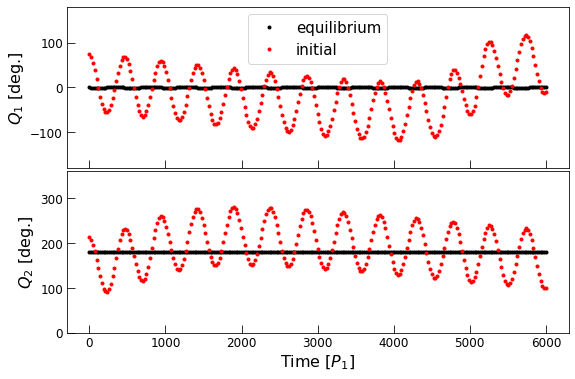

In [37]:
fig,ax = plt.subplots(2,1,figsize = (9,6),sharex=True)
plt.subplots_adjust(hspace = 0.02)
wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
for name,col,results in zip(("equilibrium","initial"),("k","r"),[results_eq,results_no_eq]):
    theta = np.array([-2,3]) @ results['l'] - results['pomega']
    theta = wrap2pi(theta)
    ax[0].plot(results['time'],180 * theta[0]/np.pi,'.',color=col,label=name)
    ax[1].plot(results['time'],np.mod(180 * theta[1]/np.pi,360),'.',color=col)
plt.sca(ax[0])
plt.legend(fontsize=15)
for a in ax:
    plt.sca(a)
    plt.tick_params(labelsize=12,direction='in',size=8)
ax[0].set_ylim(-180,180)
ax[1].set_ylim(0,360)
ax[0].set_ylabel("$Q_1$ [deg.]",fontsize=16)
ax[1].set_ylabel("$Q_2$ [deg.]",fontsize=16)
ax[1].set_xlabel("Time [$P_1$]",fontsize=16)

# Application: Resonant equilibrium configuration
- `rebound` $N$-body of equilibrium configuration versus initial configuration.

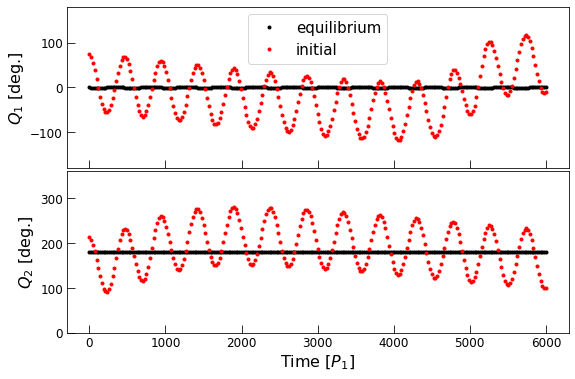

In [38]:
fig

# Co-orbital resonance and "custom" Hamiltonians
- Co-orbital resonance occurs for planets with ~equal semi-major axes

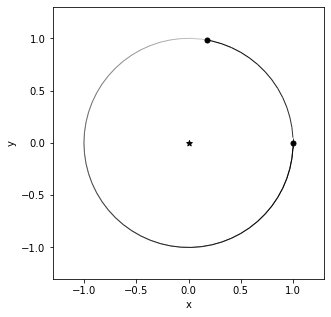

In [39]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5,a=1)
sim.add(m=1e-5,a=1,l=(60 + 20) * np.pi/ 180)
sim.move_to_com()
rebound.OrbitPlot(sim);

# Co-orbital resonance and "custom" Hamiltonians
- Characterized by libration of $\psi :=\lambda_1 - \lambda_2$

In [40]:
Nout = 200
times = np.linspace(0,1e3,Nout)
a_rb = np.zeros((2,Nout))
psi_rb = np.zeros(Nout)
for i,t in enumerate(times):
    sim.integrate(t)
    psi_rb[i] = sim.particles[1].l - sim.particles[2].l
    for j,p in enumerate(sim.particles[1:]):
        a_rb[j,i] = p.a
wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi)- np.pi
psi_rb= wrap2pi(psi_rb)

Text(0.5, 0, 'Time')

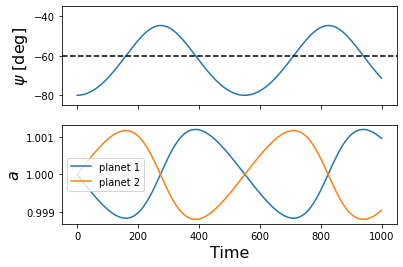

In [41]:
fig,ax= plt.subplots(2,1,sharex=True)
ax[0].plot(times,wrap2pi(psi_rb) * 180 /np.pi)
ax[0].set_ylim(-60-25,-60+25)
ax[0].axhline(-60,color='k',ls='--')
ax[0].set_ylabel("$\psi$ [deg]",fontsize=16)
for i in range(2):
    ax[1].plot(times,a_rb[i],label="planet {}".format(i+1))
plt.legend()
ax[1].set_ylabel("$a$",fontsize=16)
ax[1].set_xlabel("Time",fontsize=16)

# Co-orbital resonance and "custom" Hamiltonians
- The classical disturbing function expansion diverges for $\alpha = 1$
- Can still use ``celmech`` by using creating and adding custom terms to Hamiltonian
- We'll add interactions at 0th order in $e$ and $I$ (see [Robutel & Pousse (2013)](https://ui.adsabs.harvard.edu/abs/2013CeMDA.117...17R/abstract) for higher-order development)

In [42]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5,a=1)
sim.add(m=1e-5,a=1,l=(60 + 20) * np.pi/ 180)
sim.move_to_com()

In [43]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)

# Get parameters
from sympy import symbols, sqrt, cos
G,mu1,m1,M1,_,_,_,mu2,m2,M2,_,_ = list(pham.H_params.keys())
a1,a2 =symbols("a(1:3)",positive=True)
l1,l2 = pham.qp_vars[0],pham.qp_vars[3]
# interaction potentail to 0th order in e
phi0 = - G * m1 * m2 / sqrt(a1*a1  + a2 * a2 - 2 * a1 * a2 * cos(l1 - l2))
phi0 +=  G * m1 * m2 * cos(l1 - l2) / sqrt(a1 * a2)
phi0

                 G⋅m₁⋅m₂                  G⋅m₁⋅m₂⋅cos(λ₁ - λ₂)
- ───────────────────────────────────── + ────────────────────
     __________________________________        ____   ____    
    ╱   2                            2       ╲╱ a₁ ⋅╲╱ a₂     
  ╲╱  a₁  - 2⋅a₁⋅a₂⋅cos(λ₁ - λ₂) + a₂                         

# Co-orbital resonance and "custom" Hamiltonians
- Express $\phi_0$ in terms of canonical variables

In [44]:
Lmbda1,Lmbda2 = pham.qp_vars[6],pham.qp_vars[9]
psi=l1-l2
# Express a1, a2
a1_exprn = (Lmbda1/(mu1 * sqrt(G * M1)))**2
a2_epxrn = (Lmbda2/(mu2 * sqrt(G * M2)))**2
rule = dict(zip((a1,a2),(a1_exprn,a2_epxrn)))
rule

⎧        2             2   ⎫
⎪      Λ₁            Λ₂    ⎪
⎨a₁: ────────, a₂: ────────⎬
⎪           2             2⎪
⎩    G⋅M₁⋅μ₁       G⋅M₂⋅μ₂ ⎭

In [45]:
phi0.subs(rule)

                          G⋅m₁⋅m₂                                   G⋅m₁⋅m₂⋅cos(λ₁ - λ₂)      
- ──────────────────────────────────────────────────────── + ─────────────────────────────────
        __________________________________________________         __________       __________
       ╱      4           2   2                     4             ╱     2          ╱     2    
      ╱     Λ₁        2⋅Λ₁ ⋅Λ₂ ⋅cos(λ₁ - λ₂)      Λ₂             ╱    Λ₁          ╱    Λ₂     
     ╱   ────────── - ────────────────────── + ──────────       ╱   ──────── ⋅   ╱   ──────── 
    ╱     2   2   4       2         2   2       2   2   4      ╱           2    ╱           2 
  ╲╱     G ⋅M₁ ⋅μ₁       G ⋅M₁⋅M₂⋅μ₁ ⋅μ₂       G ⋅M₂ ⋅μ₂     ╲╱     G⋅M₁⋅μ₁   ╲╱     G⋅M₂⋅μ₂  

# Co-orbital resonance and "custom" Hamiltonians
- Other properties are automatically updated when the Hamiltonian is modified

In [46]:
pham.H+=phi0.subs(rule)
# Time derivative of Lambda1:
pham.N_flow[6]

                           2   2                                                   
    3.53549855094723e-21⋅Λ₁ ⋅Λ₂ ⋅sin(λ₁ - λ₂)     9.99990000099999e-21⋅sin(λ₁ - λ₂)
- ───────────────────────────────────────────── + ─────────────────────────────────
                                            3/2              _____    _____        
  ⎛      4     2   2                      4⎞                ╱   2    ╱   2         
  ⎝0.5⋅Λ₁  - Λ₁ ⋅Λ₂ ⋅cos(λ₁ - λ₂) + 0.5⋅Λ₂ ⎠              ╲╱  Λ₁  ⋅╲╱  Λ₂          

# Co-orbital resonance and "custom" Hamiltonians
- Integrate the new Hamiltonian

In [47]:
Nout = 200
times = np.linspace(0,1e3,Nout)
a_cm = np.zeros((2,Nout))
psi_cm = np.zeros(Nout)
for i,t in enumerate(times):
    pham.integrate(t)
    psi_cm[i] = pham.particles[1].l - pham.particles[2].l
    for j,p in enumerate(pham.particles[1:]):
        a_cm[j,i] = p.a
wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi)- np.pi
psi_cm= wrap2pi(psi_cm)

# Co-orbital resonance and "custom" Hamiltonians
- Comparison to $N$-body

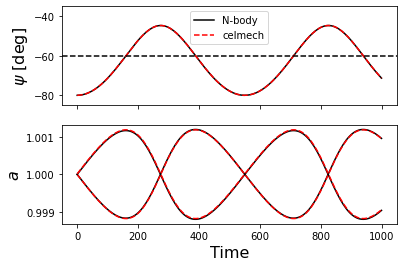

In [48]:
fig,ax= plt.subplots(2,1,sharex=True)
ax[0].plot(times,wrap2pi(psi_rb) * 180 /np.pi,'k-',label="N-body")
ax[0].plot(times,wrap2pi(psi_cm) * 180 /np.pi,'r--',label='celmech')
ax[0].set_ylim(-60-25,-60+25)
ax[0].axhline(-60,color='k',ls='--')
ax[0].set_ylabel("$\psi$ [deg]",fontsize=16)
for i in range(2):
    ax[1].plot(times,a_rb[i],'k-',label="planet {}".format(i+1))
    ax[1].plot(times,a_cm[i],'r--',label="planet {}".format(i+1))
ax[0].legend()
ax[1].set_ylabel("$a$",fontsize=16)
ax[1].set_xlabel("Time",fontsize=16);

# Co-orbital resonance and "custom" Hamiltonians
- Canonical transformation to a single degree of freedom

In [49]:
T = np.eye(pham.N_dof,dtype=int)
T[0,:2] = [1,-1]
T[1,:2] = [1,1]
ct = CanonicalTransformation.from_poincare_angles_matrix(pvars,T)
ham_1dof = ct.old_to_new_hamiltonian(pham,do_reduction=True)
for var in ham_1dof.qp_vars:
    display((var,ct.new_to_old(var)))

(Q₁, λ₁ - λ₂)

⎛    Λ₁   Λ₂⎞
⎜P₁, ── - ──⎟
⎝    2    2 ⎠

# Co-orbital resonance and "custom" Hamiltonians
- Transformed Hamiltonian

In [50]:
ham_1dof.N_H

             9.99990000099999e-21⋅cos(Q₁)                                                                                             
───────────────────────────────────────────────────── - ──────────────────────────────────────────────────────────────────────────────
│P₁ - 9.99997500129693e-6│⋅│P₁ + 9.99997500129693e-6│      ___________________________________________________________________________
                                                          ╱         4                                4                           4    
                                                        ╲╱  - 0.5⋅P₁ ⋅(-ⅈ⋅sin(Q₁) + cos(Q₁)) - 0.5⋅P₁ ⋅(ⅈ⋅sin(Q₁) + cos(Q₁)) + P₁  + 9

                                        7.07099710189446e-21                                                                          
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
______________________________________________________

# Co-orbital resonance and "custom" Hamiltonians
- Use the `H_func` method to create countours of constant energy
- Compare from $N$-body integration to energy contours

In [51]:
Ngrid = 150
# Range of psi and P1 for which to make contours
psi_range = np.linspace(30,360 - 30,Ngrid)
P1_range = np.linspace(-1e-8,+1e-8,Ngrid)
X,Y = np.meshgrid(psi_range,P1_range)
Energy = ham_1dof.H_func(X*np.pi/180,Y)

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


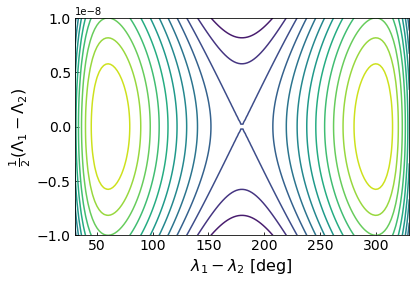

In [52]:
fig = plt.figure()
ax = plt.gca()
plt.contour(X,Y,Energy,levels=15)
plt.ylabel(r"$\frac{1}{2}(\Lambda_1-\Lambda_2)$",fontsize=16)
plt.xlabel(r"$\lambda_1 - \lambda_2$ [deg]",fontsize=16)
plt.tick_params(direction='in',labelsize=14)

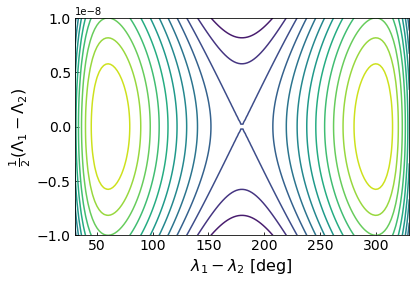

In [53]:
fig

# Co-orbital resonance and "custom" Hamiltonians
- Apply `CanonicalTransformation` to get $(Q_1,P_1)$ values directly from $N$-body integration

In [54]:
Nout= 500
times = np.linspace(0,1e3,Nout) * sim.particles[1].P
P1_nbody,Q1_nbody = np.zeros((2,Nout))
for i,t in enumerate(times):
    sim.integrate(t)
    pv = Poincare.from_Simulation(sim)
    new_vals = ct.old_to_new_array(pv.values)
    Q1_nbody[i] = new_vals[0]
    P1_nbody[i] = new_vals[6]

# Co-orbital resonance and "custom" Hamiltonians
- Compare $N$-body trajectory to constant energy contours

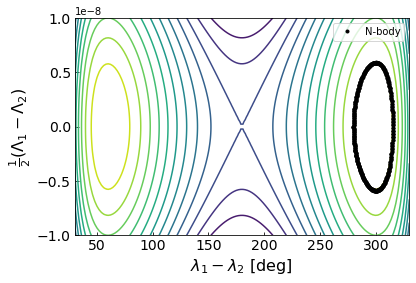

In [55]:
ax.plot(np.mod(Q1_nbody * 180/np.pi,360),P1_nbody,'k.',label='N-body')
ax.legend()
fig

# A three-body resonant system
- Three satellites in a 4:2:1 three-body resonance
- A simplified version of the Galilean satellites 
- See extended example on [GitHub](https://github.com/shadden/celmech/blob/master/jupyter_examples/ResonantChain.ipynb)

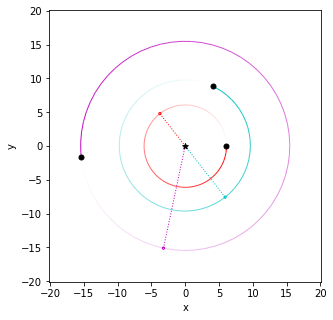

In [56]:
# Io, Europa, Ganymede
m = np.array([4.70,2.53,7.80]) * 1e-5 # mass in Jupiter masses
a = np.array([6.098,9.70,15.474]) # semi-major axis in Jupiter radii
e = np.array([0.0041, 0.0094, 0.0013]) # eccentricity
pomega = np.array([128,308,258]) * np.pi / 180 # long. of peri
l = np.array([0,1.12,3.25])
galilean_sim = rebound.Simulation()
galilean_sim.add(m=1)
for data in zip(m,a,e,l,pomega):
    galilean_sim.add(m=data[0],a=data[1],e=data[2],l=data[3],pomega=data[4])
rebound.OrbitPlot(galilean_sim,color=True,periastron=True);    

# A three-body resonant system
- Set up `pham_galilean` containing resonant interaction to 3rd order in
$e$

In [57]:
pvars = Poincare.from_Simulation(galilean_sim)
pham_galilean = PoincareHamiltonian(pvars)
# 2:1 MMR terms between adjacent satellites
pham_galilean.add_MMR_terms(2,1,max_order=3,indexIn=1,indexOut=2,inclinations=False)
pham_galilean.add_MMR_terms(2,1,max_order=3,indexIn=2,indexOut=3,inclinations=False)

# 4:1 MMR between Io & Europa
pham_galilean.add_MMR_terms(4,3,max_order=3,indexIn=1,indexOut=3,inclinations=False)

# Add pair-wise secular terms; defaults to 2nd order in e
for i in range(1,4):
    for j in range(i+1,4):
        print("{},{} secular terms".format(i,j))
        pham_galilean.add_secular_terms(indexIn=i,indexOut=j,inclinations=False)

1,2 secular terms
1,3 secular terms
2,3 secular terms


# A three-body resonant system
- Need to correct from *osculating* elements of full $N$-body problem to **mean** elements of analytic model
- I.e., remove rapidly oscillating terms
- See the [documentation](https://celmech.readthedocs.io/en/latest/canonical_transformations.html#the-firstordergeneratingfunction-class) for more details.

In [58]:
from celmech.lie_transformations import FirstOrderGeneratingFunction
chi = FirstOrderGeneratingFunction(pvars)
for i in range(1,4):
    for j in range(i+1,4):
        chi.add_zeroth_order_term(i,j)
chi.osculating_to_mean()

# Three-body laplace resonance
Use `CanonicalTransformation`s to transform to new resonant variables:
$$
\begin{eqnarray}
Q_1 &=& \lambda_1 -3 \lambda_2 +  2  \lambda_3\\
(x_{i},~{y_i}) &\approx& \sqrt{\Lambda_i}e_i\times\left(\cos(\lambda_3 - \lambda_2 - \varpi_i),~\sin(\lambda_3 - \lambda_2 - \varpi_i)\right)
\end{eqnarray}
$$

In [59]:
T = np.eye(pham_galilean.N_dof,dtype=int)
T[0,:6] =[1,-3,2,0,0,0]
T[1,:6] =[0,-1,2,1,0,0]
T[2,:6] =[0,-1,2,0,1,0]
T[3,:6] =[0,-1,2,0,0,1]
T[4,:6] =[0,1,-1,0,0,0]
T[5,:6] =[1,0,0,0,0,0]
# New angles
ct = CanonicalTransformation.from_poincare_angles_matrix(
    pham_galilean.state,
    T
)
ham_new = ct.old_to_new_hamiltonian(pham_galilean,do_reduction=True)
ct_p2c = CanonicalTransformation.polar_to_cartesian(
    ct.new_qp_vars,
    [1,2,3]
)
ham_new_xy = ct_p2c.old_to_new_hamiltonian(ham_new)

# Three-body laplace resonance
- Integrate...

In [60]:
ps_rb = galilean_sim.particles
ps_cm = pham_galilean.particles
Nout = 250
times = np.linspace(0,2500,Nout) * ps_rb[1].P
phi_rb,phi_cm = np.zeros((2,Nout))
for i,t in enumerate(times):
    galilean_sim.integrate(t)
    ham_new_xy.integrate(t)    
    phi_cm[i] = ham_new_xy.values[0]
    phi_rb[i] = np.array([1,-3,2]) @ np.array([p.l for p in ps_rb[1:]])

In [61]:
wrap2pi = lambda x: np.mod(x,2*np.pi)
phi_cm = wrap2pi(phi_cm)
phi_rb = wrap2pi(phi_rb)

# Three-body laplace resonance
- ... and compare

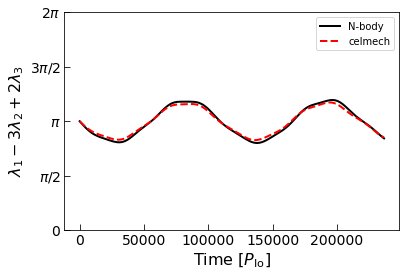

In [62]:
P1 = ps[1].P
plt.plot(times/P1,phi_rb,'k-',lw=2,label='N-body')
plt.plot(times/P1,phi_cm,'r--',lw=2,label='celmech')
plt.ylim(0,2*np.pi)
plt.legend()
plt.ylabel("$\lambda_1 - 3\lambda_2+ 2\lambda_3$",fontsize=16)
plt.xlabel("Time [$P_\mathrm{Io}$]",fontsize=16)
plt.yticks(np.linspace(0,2,5) * np.pi,["$0$","$\pi/2$","$\pi$","$3\pi/2$","$2\pi$"])
plt.tick_params(labelsize=14,direction='in',size=6)